---

### Recurrent Neural Network

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import numpy as np
import re

In [7]:
categories = ['soc.religion.christian', 'talk.politics.guns']

In [8]:
data = fetch_20newsgroups(categories=categories,remove=['headers', 'footers'])

In [9]:
data['target_names']

['soc.religion.christian', 'talk.politics.guns']

In [10]:
X = data['data']

In [11]:
y = data['target'] #0 means christianity, 1 means guns

### Text preprocessing 

* split 
* drop special characters and stop words
* tokenisation
* vectorize = we'll use keras embedding layer for that

In [16]:
def clean_text(text,label,cap):
    clean_text = []
    clean_label = []
    for i, email in enumerate(text):
        email = email.lower()
        email = re.findall('(?u)\\b\\w\\w+\\b', email)
        if len(email) <= cap:
            clean_text.append(email)
            clean_label.append(label[i])
    return clean_text, clean_label

In [ ]:
#we could split the long emails, or we could drop them
# better not to lose data, but i want my model to train fast

In [24]:
clean_X, clean_y = clean_text(X,y,300)

#### Make a vocab list

In [27]:
vocab_list = []
for email in clean_X:
    for word in email:
        vocab_list.append(word)
        
vocab_list = list(set(vocab_list))
vocab_size = len(vocab_list) + 1

#### Make a dictionary for words to numbers - an index but not like full text search!

In [28]:
word_to_num = {}

for i, word in enumerate(vocab_list):
    word_to_num[word] = i+1 #i+1 because we're reserving 0 for blank space

In [32]:
vec_X = [[word_to_num[word] for word in email] for email in clean_X]

#### find the max length of the text, then pad all seqeunces to match that length - input shape in NN has to be consistent!!

In [30]:
max_len = 0
position = 0
for i, email in enumerate(clean_X):
    if len(email) > max_len:
        max_len = len(email)
        position = i
max_len, position

(299, 82)

#### Lets pad the sequences

In [36]:
pad_vec_X = sequence.pad_sequences(vec_X, maxlen=max_len,padding='pre')

In [37]:
pad_vec_X[5]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

---

#### This is what we've done in RNNs so far
* download test emails
* removed special characters
* transformed the words into numbers
* cast them into a list
* padded them with zeroes so every email number list has the same length

#### This is what we have to do now
* initialise an lstm
* train in on the Xtrain data 
* test it on our Xtest data

In [43]:
from sklearn.model_selection import train_test_split

In [46]:
Xtrain, Xtest, ytrain, ytest = train_test_split(pad_vec_X, np.array(clean_y))

---

#### Now lets create the model
We build a sequential model

Then add an Embedding layer

This layer takes 3 parameters - the size of the vocab (input_dims), the no. of dimensions of each word embedding (output_dim), and the length of each document (input_length), which we've standardised above. It returns a 2d matrix, with rows equal to each word in the document, and columns equal to the number of dimensions in the word embedding. 

*Actually its 3D, cos the batch_size is the first dimension in both input and output, but I find that confuses things more than it clarifies*
Put another way 

The embedding **takes in** a factorized corpus, e.g.:

**[The, cat, sat, on, the, mat]**    becomes    **[1,2,3,4,1,5]**

And **outputs** a word embedded corpus:

**[1,2,3,4,1,5]**    becomes (lets assume output_dim=2)   **[[0.2,0.7], [0.6,0.3], [0.1,0.8], [0.2,0.1], [0.4,0.9], [0.2,0.7]]**

In [47]:
model = Sequential()

In [49]:
model.add(Embedding(input_dim=vocab_size, output_dim=32,input_length=max_len))

In [50]:
model.add(LSTM(128)) #units? if no.units > max_len, likely to overfit

In [51]:
model.add(Dense(1, activation='sigmoid'))

---

In [113]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [114]:
history = model.fit(Xtrain,ytrain,epochs=20, batch_size=64, validation_split=0.2)

Train on 456 samples, validate on 114 samples
Epoch 1/20
456/456 [==============================] - 5s 11ms/sample - loss: 0.6481 - accuracy: 0.8860 - val_loss: 0.6555 - val_accuracy: 0.7632
Epoch 2/20
456/456 [==============================] - 3s 7ms/sample - loss: 0.4918 - accuracy: 0.9693 - val_loss: 0.5805 - val_accuracy: 0.7719
Epoch 3/20
456/456 [==============================] - 3s 7ms/sample - loss: 0.3583 - accuracy: 0.9013 - val_loss: 0.5272 - val_accuracy: 0.7982
Epoch 4/20
456/456 [==============================] - 3s 8ms/sample - loss: 0.2177 - accuracy: 0.9825 - val_loss: 0.3342 - val_accuracy: 0.8860
Epoch 5/20
456/456 [==============================] - 3s 7ms/sample - loss: 0.1323 - accuracy: 0.9759 - val_loss: 0.4709 - val_accuracy: 0.7807
Epoch 6/20
456/456 [==============================] - 3s 7ms/sample - loss: 0.1208 - accuracy: 0.9846 - val_loss: 0.1746 - val_accuracy: 0.9386
Epoch 7/20
456/456 [==============================] - 3s 8ms/sample - loss: 0.1405 - accu

In [115]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

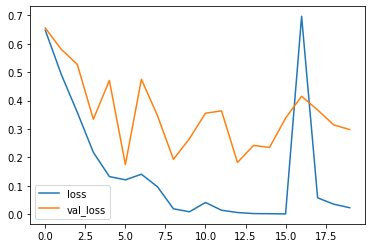

In [117]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

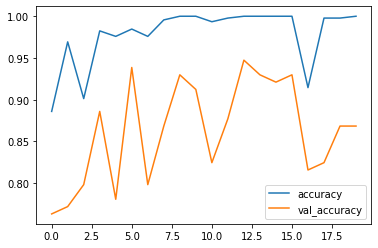

In [116]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

In [118]:
model.evaluate(Xtest,ytest)

191/191 [==============================] - 1s 4ms/sample - loss: 0.4535 - accuracy: 0.8482


[0.453461260539699, 0.84816754]

---

In [ ]:
#### This function allows you to test the model on a new string

In [124]:
def test_model(string, model):
    clean_X, clean_y = clean_text([string], [0], 300)
    vec_X = [[word_to_num[word] for word in email if word in vocab_list] for email in clean_X]
    pad_vec_X = sequence.pad_sequences(vec_X, maxlen=max_len,padding='pre')
    return 'christian' if model.predict(pad_vec_X)[0] <= 0.5 else 'guns'

---

#### Conclusion
* LSTM are v good on sequential data BUT
* Overfit easily - how can treat for that?
* And they still suffer from - word sense disambiguation, long long term memory isn't captured

---